## Global Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import time

## Setup Jupyter Notebook data visualisaton params

In [2]:
from pylab import rcParams
import seaborn as sb

%matplotlib inline
rcParams['figure.figsize'] = 15, 12
sb.set_style('whitegrid')

## Import dataset

In [3]:
address = '../datasets/staandelamp_realistic.json'
df_data = pd.read_json(address)

# Sort the data on timestamp
df_data = df_data.sort_values(by=['time'])

# Grab around 6 hours of timestamps
### TEMP ###
df_data = df_data[:42]
### TEMP ###

print(df_data.shape)

df_data.head()

(42, 3)


,name,state,time
2,Staande_Lamp_3,0,1509489940655
6,Staande_Lamp_5,1,1509490011225
0,Staande_Lamp_1,1,1509491943009
1,Staande_Lamp_2,0,1509492221471
3,Staande_Lamp_3,1,1509492826941


### (optional) Make a dataset for debugging purposes (so the date and time is human-readable) 

In [4]:
import datetime
import time
df_printable_dates = pd.DataFrame()
df_printable_dates['time'] = df_data['time']
df_printable_dates['printable_dates'] = df_data['time'].map(lambda x: datetime.datetime.fromtimestamp(x / 1000).isoformat())

df_printable_dates.head()

,time,printable_dates
2,1509489940655,2017-10-31T23:45:40.655000
6,1509490011225,2017-10-31T23:46:51.225000
0,1509491943009,2017-11-01T00:19:03.009000
1,1509492221471,2017-11-01T00:23:41.471000
3,1509492826941,2017-11-01T00:33:46.941000


# Determine the number of clusters (linkage)

#### only interested in column TIME

In [5]:

X = df_data.iloc[ :, [2] ].values
#                 :        All the rows
#                    [2]   Only column 2 (time)

X[:5]

array([[1509489940655],
       [1509490011225],
       [1509491943009],
       [1509492221471],
       [1509492826941]], dtype=int64)

##### Plot the timestamps and a line indicating 5 minutes

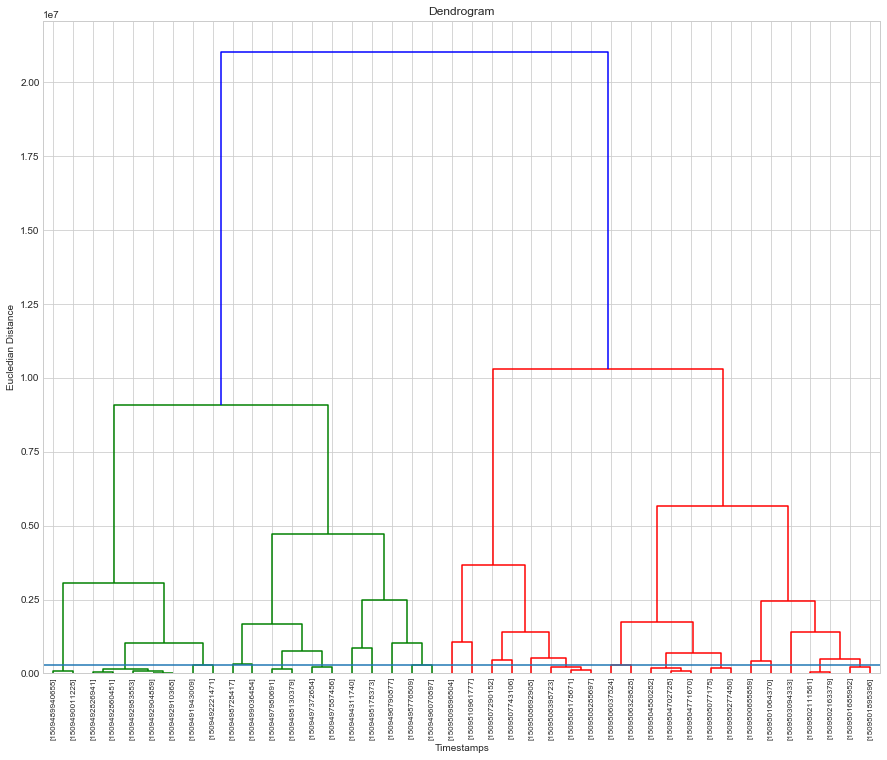

In [6]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(X, method='complete')

gram = dendrogram(
    Z, 
    labels=X,
    # truncate_mode='lastp', 
    # p=12, 
    # leaf_rotation=45., 
    # leaf_font_size=15., 
    # show_contracted=True
)
plt.title('Dendrogram')
plt.xlabel('Timestamps')
plt.ylabel('Eucledian Distance')

# This line represents a distance of 5 minutes
plt.axhline(y=300000)

In [7]:
# Debug Z

five_minutes = 300000

clusters_with_distance_of_five_minutes_or_less = 0
for idx, val in enumerate(Z):
    
    # Count Z with a distance of less than 10 minutes
    if(val[2] < five_minutes): 
        clusters_with_distance_of_five_minutes_or_less += 1
    
    # debug a couple of the Z's
    if(idx == 0 or idx == 1 or idx == 2):
        print('cluster:', idx, '\nval:', val, '\n')

cluster: 0 
val: [6.000e+00 7.000e+00 5.479e+03 2.000e+00] 

cluster: 1 
val: [4.000e+00 5.000e+00 3.351e+04 2.000e+00] 

cluster: 2 
val: [2.4000e+01 2.5000e+01 5.1818e+04 2.0000e+00] 



In [8]:
total_number_of_clusters = Z.shape[0]
print(
    clusters_with_distance_of_five_minutes_or_less, 
    'of', 
    total_number_of_clusters, 
    'clusters have a distance less than 5 minutes OR SOMETHING'
)

17 of 41 clusters have a distance less than 5 minutes OR SOMETHING


# AgglomerativeClustering

In [9]:
## Format the dataset to be all numbers

In [10]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

print('before:\n', df_data.head())

d = defaultdict(LabelEncoder)
df_fit = df_data.apply(lambda x: d[x.name].fit_transform(x))
df_fit['time'] = df_data['time']
print('after:\n', df_fit.head())

before:
              name  state           time
2  Staande_Lamp_3      0  1509489940655
6  Staande_Lamp_5      1  1509490011225
0  Staande_Lamp_1      1  1509491943009
1  Staande_Lamp_2      0  1509492221471
3  Staande_Lamp_3      1  1509492826941
after:
    name  state           time
2     2      0  1509489940655
6     4      1  1509490011225
0     0      1  1509491943009
1     1      0  1509492221471
3     2      1  1509492826941


In [11]:
from sklearn.cluster import AgglomerativeClustering
import sklearn.metrics as sm

# amountOfDataRows = df_fit['name'].size

model = AgglomerativeClustering(
    affinity='euclidean', 
    compute_full_tree='auto',
    connectivity=None, 
    linkage='complete', 
    memory=None, 
    n_clusters=clusters_with_distance_of_five_minutes_or_less,
    pooling_func='deprecated'
)

model

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='complete', memory=None,
            n_clusters=17, pooling_func='deprecated')

In [12]:
#sm.accuracy_score(df_data.iloc[:, (2)], model.labels_)

predicted_clusters = model.fit(df_fit).labels_

In [13]:
# predicted_clusters = model.fit_predict(df_fit)
# predicted_clusters

In [14]:
### Find outliers

In [15]:
outlier_dict = {}
for i in model.labels_: outlier_dict[i] = i in outlier_dict
outliers = [k for k in outlier_dict if not outlier_dict[k]]

print('outliers:\n', outliers)

outliers:
 [16, 12, 14, 13]


In [16]:
### Make a color map for all groups and outliers (for plotting)

In [17]:
COLOR_MAP = {}
group_count = 0;
for n in set(model.labels_):
    if n in outliers:
        COLOR_MAP[n] = 'lightgrey'
    else:
        group_count += 1
        if group_count % 7 == 0:
            COLOR_MAP[n] = 'firebrick'
        elif group_count % 7 == 1:
            COLOR_MAP[n] = 'darkgreen'
        elif group_count % 7 == 2:
            COLOR_MAP[n] = 'purple'
        elif group_count % 7 == 3:
            COLOR_MAP[n] = 'darkorange'
        elif group_count % 7 == 4:
            COLOR_MAP[n] = 'Teal'
        elif group_count % 7 == 5:
            COLOR_MAP[n] = 'Olive'
        elif group_count % 7 == 6:
            COLOR_MAP[n] = 'Green'
        else:
            COLOR_MAP[n] = 'darkblue'

print('All of the datapoints:\n', model.labels_)
print('One color for each datapoint:\n', set(model.labels_))

All of the datapoints:
 [15 15  8  8  7  7  7  7  7  0  0  3  3 16  1  1  1  1 11 11  9  9  4  4
  4  4 12  2  2  2  2  2 10 10  6  6  5  5  5  5 14 13]
One color for each datapoint:
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}


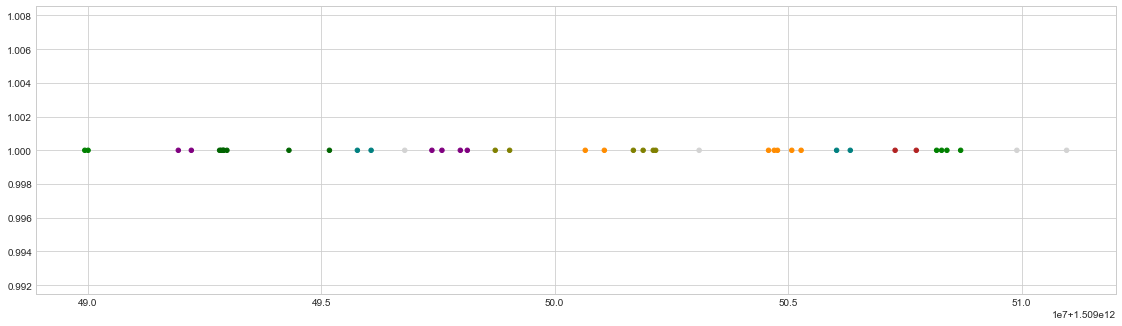

In [18]:
# Make figure smaller:
rcParams['figure.figsize'] = 15, 4

fig = plt.figure()
ax = fig.add_axes([.1, .1, 1, 1])

colors = [COLOR_MAP[l] for l in model.labels_]

# use first column as X value
XX = df_fit.iloc[:,2]
# set nr 1 as the value for y so it will be 1Dimentional
YY = [1] * df_fit.shape[0]

ax.scatter(XX, YY, c=colors, s=20)
ax.set_xlabel = 'time'
plt.title = 'Groupingz'
